In [1]:
%cd /home/pac/gits/phd/mri-online/

/home/pac/gits/phd/mri-online


In [2]:
import yaml
import pprint
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import tikzplotlib as tikz
from results.base import Experience, loader
from results.plot import plot_metrics, plot_line, make_gif

from project_utils import implot, imsave, load_data
from online.metrics import psnr_ssos, ssim_ssos, ssos

/home/pac/gits/phd/pysap-mri/mri/operators/fourier/non_cartesian.py:27: UserWarning: pynfft python package has not been found. If needed use the master release.
  warnings.warn("pynfft python package has not been found. If needed use "
/home/pac/gits/phd/pysap-mri/mri/operators/fourier/non_cartesian.py:42: UserWarning: gpuNUFFT python package has not been found. If needed please check on how to install in README
  warnings.warn("gpuNUFFT python package has not been found. If needed "


In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 200
DATA_DIR = "data/"
PLOT_DIR = "/home/pac/gits/rep/report-mri-online/plot/"

TIKZ_DICT={'override_externals':True,
           'axis_width':'\\mywidth',
           'axis_height':'\\myheight',
           'extra_axis_parameters':['y tick label style={font=\\footnotesize}','x tick label style={font=\\footnotesize}','ylabel style={font=\\footnotesize}','xlabel style={font=\\footnotesize}','legend style={font=\\footnotesize}',]}

full_k, real_img, mask_loc, final_mask = load_data(DATA_DIR,1)
square_mask= np.zeros(real_img.shape)
real_img_size = real_img.shape
img_size = [min(real_img.shape)]*2
square_mask[real_img_size[0] // 2 - img_size[0] // 2:real_img_size[0] // 2 + img_size[0] // 2,
            real_img_size[1] // 2 - img_size[1] // 2:real_img_size[1] // 2 + img_size[1] // 2] = 1

default_weight=2e-6

In [4]:
with open('results/tested_config.yml') as f:
    tested_cfg = yaml.load(f, Loader=loader)
Experience.save_folder = 'results/simuls/'
Experience.objects.flush()
for cfg in tested_cfg:
    Experience.objects.add(Experience(**cfg))
    
    
monocoil= Experience.objects.filter(mode='and',data__monocoil=True)

## Regularisation 
### Forward-Backward

In [5]:
default_case = monocoil.filter(mode='and',
                       problem__fourier_type=0,
                       problem__regularisation__class='LASSO',
                       problem__regularisation__weights=default_weight,
                       solver__algo__in=['pogm'])
print(type(default_case))
                                       
off =  default_case.pop()                               
img = off.xf[-1] 
implot(img,  mask=square_mask, title=f'psnr={psnr_ssos(img,real_img, mask=square_mask):.4f}dB ssim={ssim_ssos(img,real_img, mask=square_mask):.2f}');
imsave(img, PLOT_DIR +'offline_vanilla.png',mask=square_mask)
imsave(real_img, PLOT_DIR +'ground_truth_square.png',mask=square_mask)
plt.figure()
plt.plot(real_img[320],label='ref')
plt.plot(img[320],label='offline')

<class 'experiences.set.ExperienceSet'>


KeyError: 'pop from an empty set'

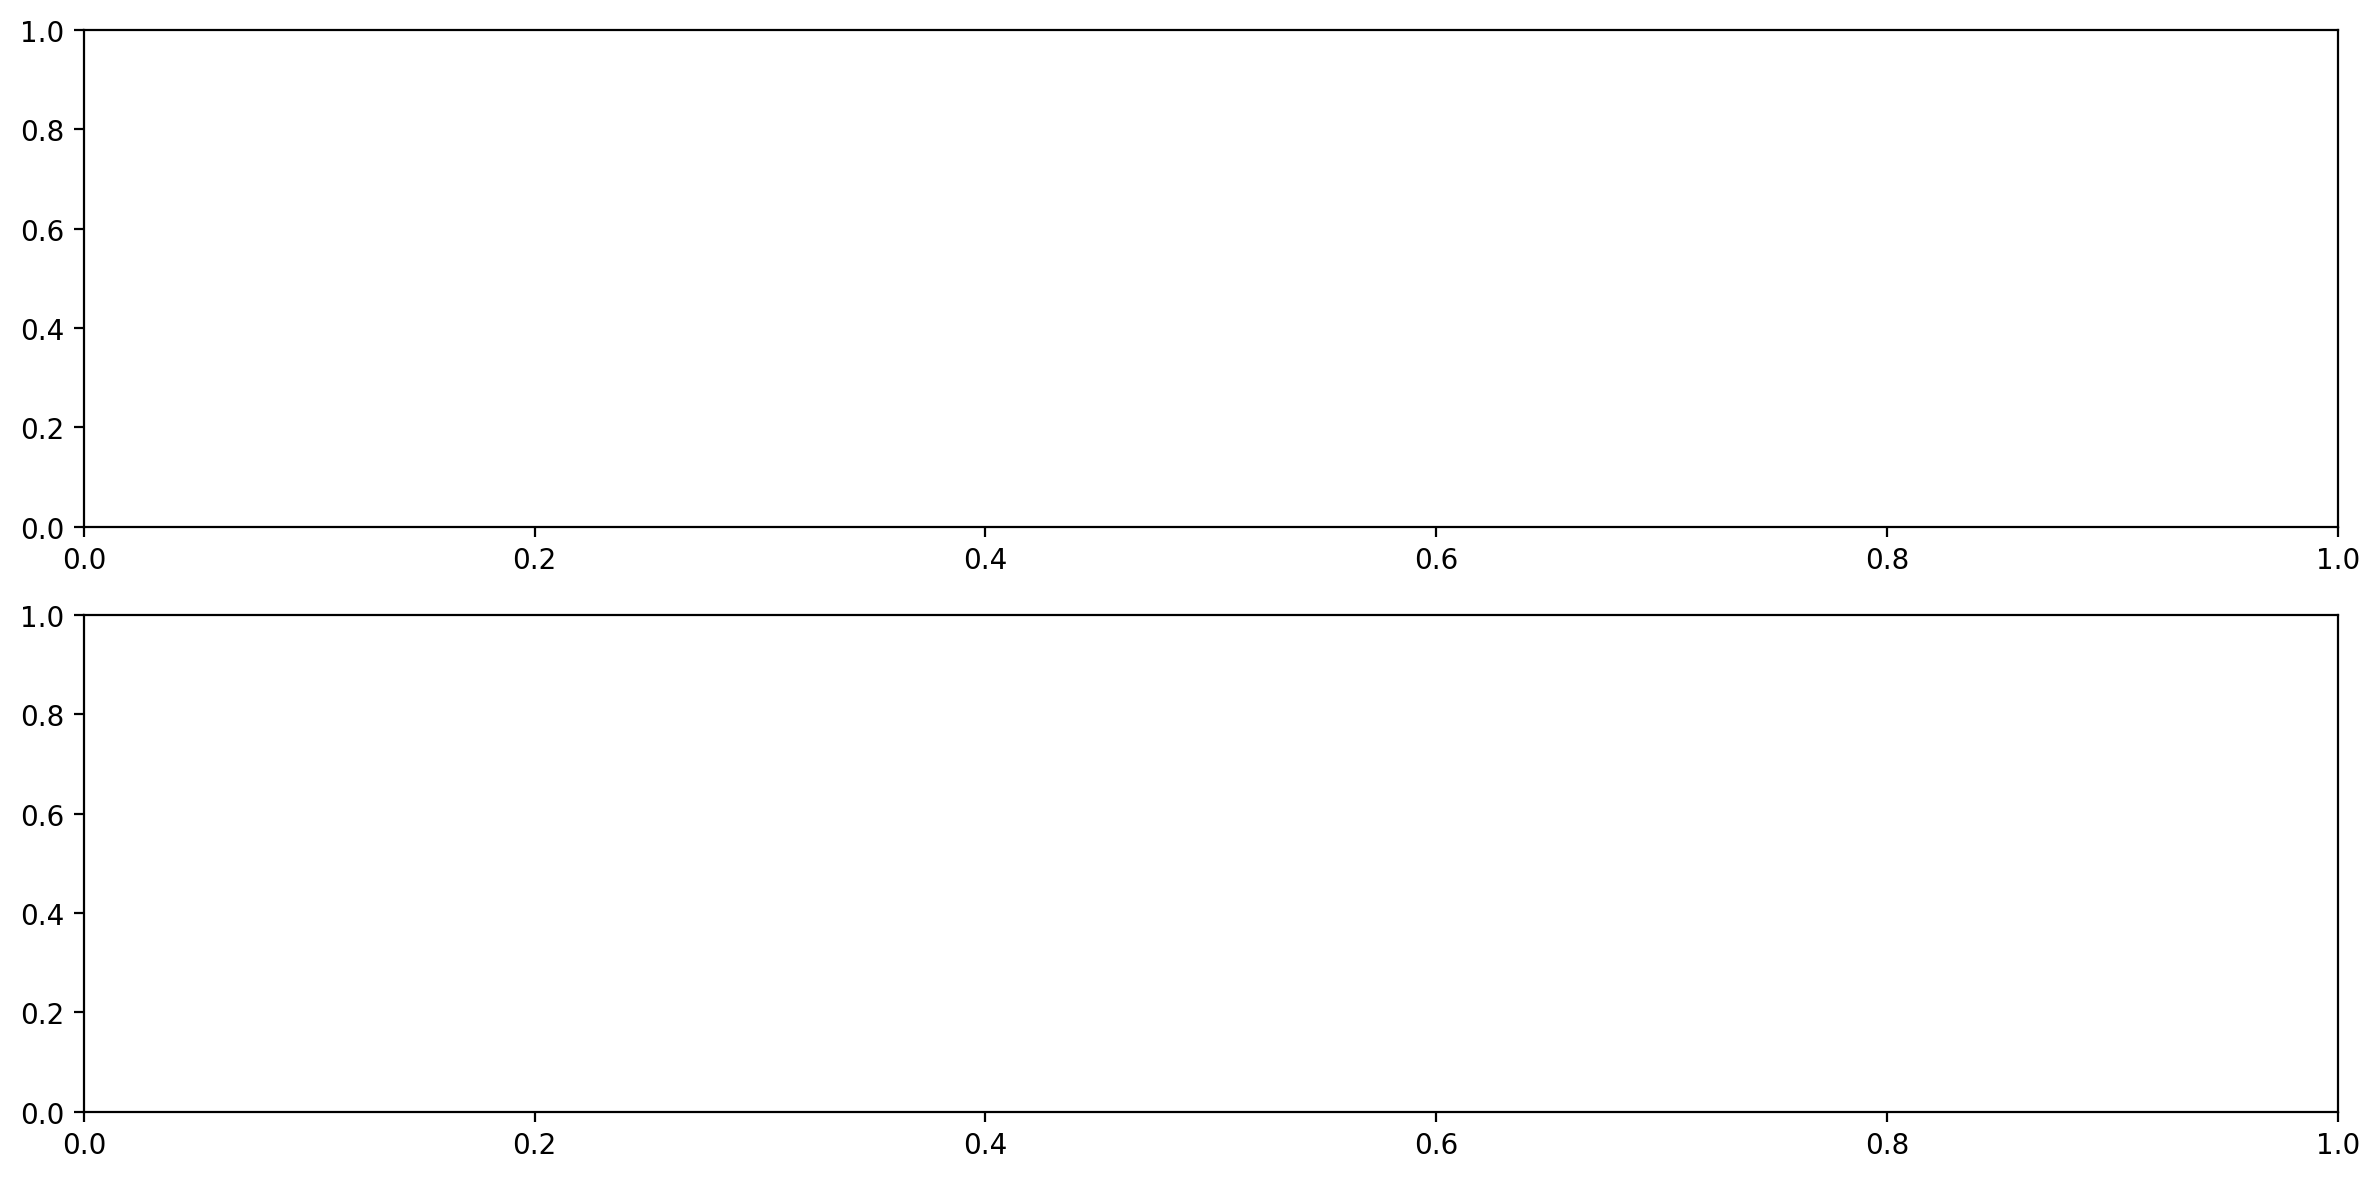

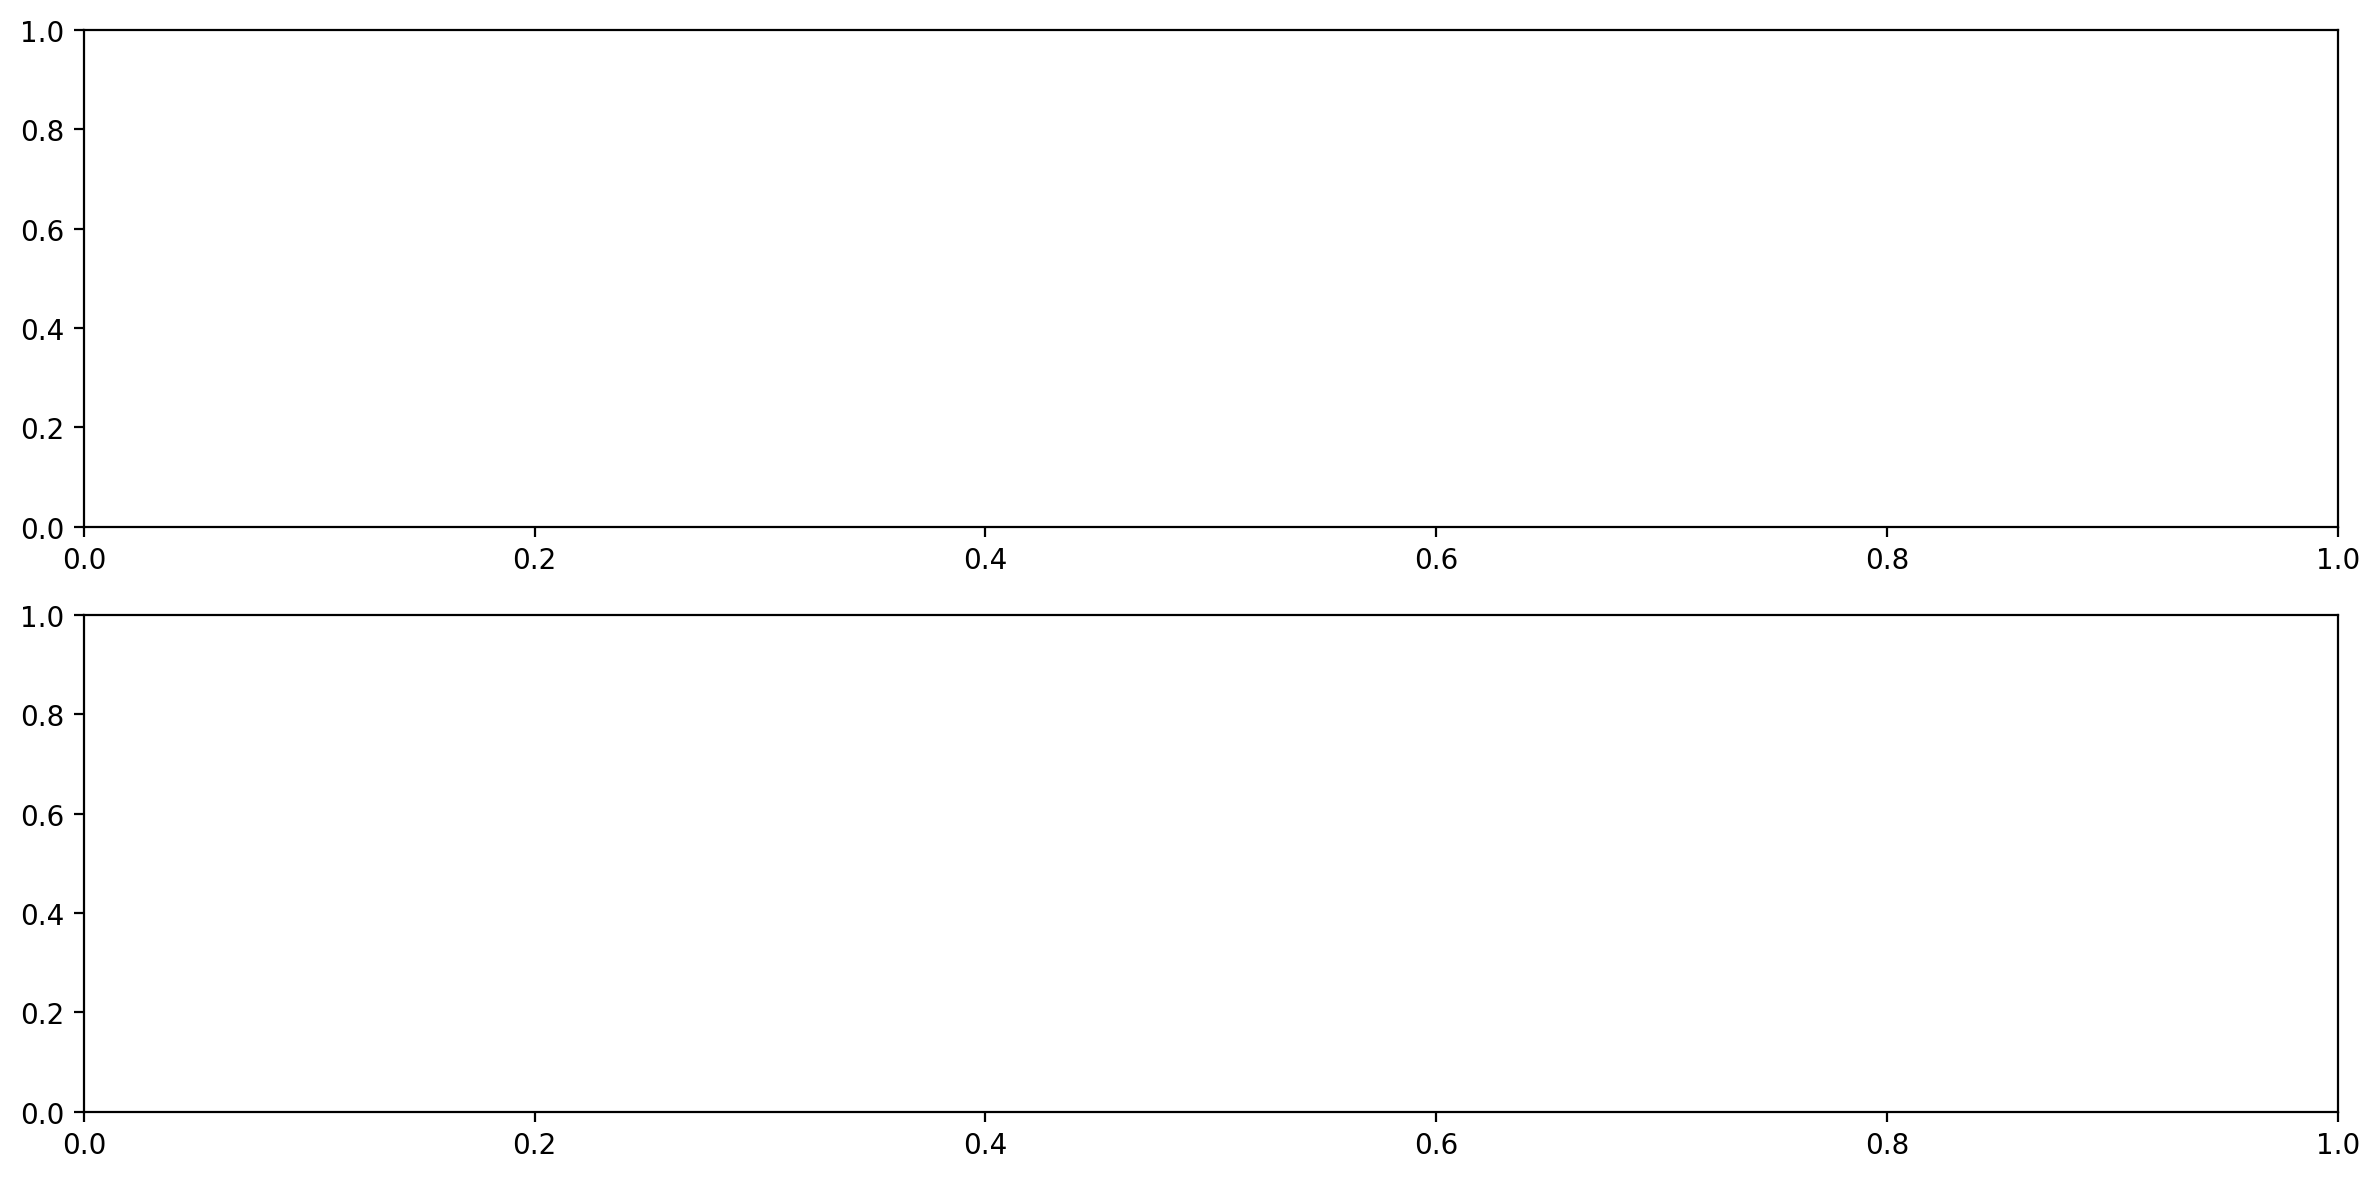

In [8]:
offline = monocoil.filter(mode='and', problem__fourier_type=0, solver__nb_run=1)

f = plot_metrics(offline, ('cost_off', 'cost'), [],default_offset=0,log=True)
f = plot_metrics(offline, ('psnr', 'ssim'), [], default_offset=0,log=False)

In [ ]:
online1 =monocoil.filter(mode='and', problem__fourier_type__in=[1],solver__nb_run=2,solver__algo__in=['condatvu','pogm','vanilla'],
                                                            problem__regularisation__class__in=['LASSO'],
                                                            problem__regularisation__weights=2e-6,)

online2 =  monocoil.filter(mode='and', problem__fourier_type=2,solver__nb_run=2,solver__algo__in=['condatvu','pogm','vanilla'],solver__reg_factor=0.0125,
                                                            problem__regularisation__class__in=['LASSO'],
                                                            problem__regularisation__weights=2e-6,)
online2 = online2.filter(mode='loose_and', solver__eta=1.0)
online1 = online1.union(offline).union(online2)
f = plot_metrics(online1, metrics=('cost_off', 'cost'),ignore_keys=['nb_run','reg_factor','eta'], default_offset=80,log=True)
tikz.save(PLOT_DIR+'cost_classical.tikz', **TIKZ_DICT)

f = plot_metrics(online1, metrics=('data_res_off', 'prox_cost'),ignore_keys=['nb_run','reg_factor','eta'], default_offset=80,log=True)
tikz.save(PLOT_DIR+'cost_classical.tikz', **TIKZ_DICT)
f = plot_metrics(online1, metrics=('psnr', 'ssim'), ignore_keys=['nb_run','reg_factor','eta'], default_offset=80,log=False)
tikz.save(PLOT_DIR+'metrics_classical.tikz', **TIKZ_DICT)


In [ ]:
online1 = monocoil.filter(mode='and', problem__fourier_type__in=[1,2],
                                    problem__regularisation__class__in=['LASSO','IdentityProx'],
                                    problem__regularisation__weights=2e-6,
                                    solver__algo='condatvu',
                                    solver__nb_run=1).filter(results__psnr__max__ge=20)
online1 = online1.union(offline)
f = plot_metrics(online1, metrics=('cost_off', 'cost'), default_offset=0,log=True)
f = plot_metrics(online1, metrics=('psnr', 'ssim'), default_offset=0,log=False)

online1 = monocoil.filter(mode='and', problem__fourier_type__in=[1,2],
                                    problem__regularisation__class__in=['LASSO','IdentityProx'],
                                    problem__regularisation__weights=2e-6,
                                    solver__algo='vanilla',
                                    solver__nb_run=1).filter(results__psnr__max__ge=20)
online1 = online1.union(offline)
f = plot_metrics(online1, metrics=('cost_off', 'cost'), default_offset=0,log=True)
f = plot_metrics(online1, metrics=('psnr', 'ssim'), default_offset=0,log=False)

In [ ]:
online1 = monocoil.filter(mode='and', problem__fourier_type__in=[1,2],
                                    problem__regularisation__class__in=['LASSO','IdentityProx'],
                                    problem__regularisation__weights=2e-6,
                                    solver__algo__in=['vanilla','momentum'],
                                    solver__reg_factor=1.,
                                    solver__nb_run=1)
f = plot_metrics(online1, metrics=('cost_off', 'cost'), default_offset=0,log=True)
f = plot_metrics(online1, metrics=('psnr', 'ssim'), default_offset=0,log=False)
tikz.save(PLOT_DIR+'metrics_momentum.tikz', **TIKZ_DICT)


In [ ]:
offline_id = monocoil.filter(mode='and', problem__fourier_type=0, solver__nb_run=1,).filter(mode='loose_and',
                                   problem__regularisation__class__in=["IdentityProx",],
                                )

online1 =monocoil.filter(mode='and', problem__fourier_type__in=[1],solver__nb_run=2,solver__algo__in=['condatvu','pogm','vanilla'],
                                                            problem__regularisation__class__in=['IdentityProx'])

online2 =  monocoil.filter(mode='and', problem__fourier_type=2,solver__nb_run=2,solver__algo__in=['condatvu','pogm','vanilla'],solver__reg_factor=0.0125,
                                                            problem__regularisation__class__in=['IdentityProx'])
online1 = online1.union(offline_id).union(online2)
f = plot_metrics(online1, metrics=('cost_off', 'cost'), default_offset=80,log=True)
tikz.save(PLOT_DIR+'cost_classical_id.tikz', **TIKZ_DICT)

f = plot_metrics(online1, metrics=('psnr', 'ssim'), default_offset=80,log=False)
tikz.save(PLOT_DIR+'metrics_classical_id.tikz', **TIKZ_DICT)

In [ ]:
from array2gif import write_gif
import numpy as np
from IPython.display import Image


def make_gif(exp, **kwargs):
    """
    Create a gif from the estimates
    """
    estimates = abs(np.array(exp.xf))
    estimates = np.repeat(estimates[:,np.newaxis,...],3,axis=1)
    estimates *= (255.0/estimates.max())
    print(estimates.shape)
    filename = f"{hash(exp)}.gif"
    write_gif(estimates, filename, **kwargs)